# Things to do
    - add humidity column
    - add weekday column
    - one hot encoder cbwd and weekday columns
    - fill NaN with not NaN before
    - outliers
    - add past data columns

In [1]:
import pandas as pd
import numpy as np
from math import exp, isnan
from datetime import datetime
from matplotlib import pyplot as plt
from plotly import express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


## Add humidity column

In [3]:
def cal(temp, dewp):
    return 100*(exp((17.625*dewp)/(243.04+dewp))/exp((17.625*temp)/(243.04+temp)))
df['hum'] = [cal(temp, dewp) for temp, dewp in zip(df['TEMP'], df['DEWP'])]

## Add weekday column

In [4]:
weekday = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
tmp = []
for i, j, k in zip(df['day'], df['month'], df['year']):
    date = weekday[datetime.strptime(str('{}/{}/{}'.format(i, j, k)), '%d/%m/%Y').weekday()]
    tmp.append(date)
df['weekday'] = tmp

## One Hot Encoder cbwd and weekday columns

In [5]:
df = pd.get_dummies(df)

## Fill NaN with not NaN before

In [6]:
df['pm2.5'].isna().sum()

2067

In [7]:
pre = -1
tmp = []
for i in df['pm2.5']:
    if not isnan(i):
        pre = i
    tmp.append(pre)
df['pm2.5'] = tmp
df = df[df['pm2.5'] != -1]

In [8]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,cbwd_NW,cbwd_SE,cbwd_cv,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,...,0,1,0,1,0,0,0,0,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,...,0,1,0,1,0,0,0,0,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,...,0,1,0,1,0,0,0,0,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,...,0,1,0,1,0,0,0,0,0,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,231.97,...,1,0,0,0,0,0,0,0,1,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,237.78,...,1,0,0,0,0,0,0,0,1,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,242.70,...,1,0,0,0,0,0,0,0,1,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,246.72,...,1,0,0,0,0,0,0,0,1,0


## Outliers

In [9]:
dic = {}
for day, month, year, hour, pm25 in zip(df['day'], df['month'], df['year'], df['hour'], df['pm2.5']):
    dic[datetime.strptime(str('{}/{}/{} {}:00'.format(day, month, year, hour)), '%d/%m/%Y %H:%M')] = pm25

In [10]:
outlier_df = pd.DataFrame.from_dict(dic, orient='index', columns=['Value'])

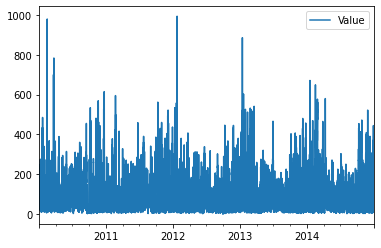

In [11]:
outlier_df.plot()
plt.show()

In [12]:
df = df[df['pm2.5'] <= 600]

## Add past data columns

In [13]:
need_shift = ['pm2.5', 'DEWP', 'TEMP', 'Iws']
for var in need_shift:
    for i in range(1, 10):
        key = var + '_' + str(i)
        df[key] = df[var].shift(periods=i)
df.dropna(inplace=True)

/home/h32lab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/h32lab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'Iws', 'Is', 'Ir', 'hum', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv',
       'weekday_Fri', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'pm2.5_1', 'pm2.5_2',
       'pm2.5_3', 'pm2.5_4', 'pm2.5_5', 'pm2.5_6', 'pm2.5_7', 'pm2.5_8',
       'pm2.5_9', 'DEWP_1', 'DEWP_2', 'DEWP_3', 'DEWP_4', 'DEWP_5', 'DEWP_6',
       'DEWP_7', 'DEWP_8', 'DEWP_9', 'TEMP_1', 'TEMP_2', 'TEMP_3', 'TEMP_4',
       'TEMP_5', 'TEMP_6', 'TEMP_7', 'TEMP_8', 'TEMP_9', 'Iws_1', 'Iws_2',
       'Iws_3', 'Iws_4', 'Iws_5', 'Iws_6', 'Iws_7', 'Iws_8', 'Iws_9'],
      dtype='object')

In [15]:
features = list(df.columns[8:])
predicts = list(df.columns[5:8])

In [33]:
predicts += [i + '_1' for i in predicts]

In [34]:
predicts

['pm2.5', 'DEWP', 'TEMP', 'pm2.5_1', 'DEWP_1', 'TEMP_1']

In [36]:
for i in predicts:
    if i in features:
        features.remove(i)

In [41]:
features.remove('Iws_1')

In [57]:
df.dropna(inplace=True)

In [58]:
X = df[features]
y = df[predicts]

In [59]:
X.shape

(43757, 48)

In [60]:
y.shape

(43757, 6)

In [61]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.05)

## Modeling

In [62]:
linear = LinearRegression()

In [63]:
linear.fit(Xtrain, ytrain)
linear.score(Xtrain, ytrain)

0.9618152768388586

In [64]:
for i in range(100):
    linear.fit(Xtrain, ytrain)

In [65]:
linear.fit(Xtrain, ytrain)
linear.score(Xtrain, ytrain)

0.9618152768388586

In [66]:
ytest = ytest.values

In [67]:
def cal():
    data = [0] * 3
    for i in range(len(predict)):
        for j in range(3):
            data[j] += abs(predict[i][j] - ytest[i][j])
    for i in range(3):
        data[i] /= len(predict)
    return (data[0], data[1], data[2])

In [68]:
predict = linear.predict(Xtest)
print('R^2 score:', r2_score(predict, ytest))
print('Mean Absolute Error:', mean_absolute_error(predict, ytest))

R^2 score: 0.9565386675004013
Mean Absolute Error: 5.944602256107912


In [69]:
predict = linear.predict(Xtest)
print('R^2 score:', r2_score(predict, ytest))
print('Mean Absolute Error:', mean_absolute_error(predict, ytest))

R^2 score: 0.9565386675004013
Mean Absolute Error: 5.944602256107912


In [70]:
cal()

(19.34331705729604, 1.1128324798827551, 1.1303634748167102)

In [ ]:
sum([12.220328459541111, 0.8129828010090021, 0.8342715266273949]) / 3

## Predict for next 6 hours

In [31]:
for i in range(6):
    tail = pd.concat([df.tail(1)], ignore_index=True)
    tail.loc[:, ['day', 'month', 'year', 'hour']] = [1, 1, 2015, i]
    df = pd.concat([df, tail], ignore_index=True)
    df.loc[len(df) - 1:, predicts] = linear.predict(tail[features])
    for var in need_shift:
        for i in range(1, 6):
            key = var + '_' + str(i)
            df[key] = df[var].shift(periods=i)

In [32]:
df.tail(6)[['day', 'month', 'year', 'hour'] + predicts]

,day,month,year,hour,pm2.5,DEWP,TEMP
43756,1,1,2015,0,7.307223,-22.224282,-4.313914
43757,1,1,2015,1,13.631180,-21.270964,-3.179296
43758,1,1,2015,2,4.422854,-22.439139,-4.549347
43759,1,1,2015,3,15.438057,-21.533454,-3.359267
43760,1,1,2015,4,0.553489,-22.676846,-4.778427
43761,1,1,2015,5,18.165441,-21.786943,-3.553587


- season
- trend
- statistical models for time serries
- how data transform by times (up or down, low or high)
- past data for weekdays or for pm2.5 last year